# Genetic diversity and population structure

This notebook examines 4fold genetic diversity in urban and rural populations, urban-rural genetic differentiation ($F_{ST}$ and PCA), and admixtures using ~1X whole-genome sequencing of 2,074 individuals across 26 cities. 

## Setup

In [1]:
# Load packages
library(MASS)
library(tidyverse)
library(car)
library(emmeans)
library(wesanderson)
library(ggrepel)
library(fs)
library(ggridges)
library(data.table)
library(RcppCNPy)
library(R.utils)
library(patchwork)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.1 (2020-08

In [2]:
# Theme used for plotting
ng1 <- theme(aspect.ratio=0.7,panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border=element_blank(),
          axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(size = 1, color="black"),
          axis.ticks.length=unit(0.25, 'cm'),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=15),
          axis.text.y=element_text(size=15),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
          strip.background = element_rect(colour="black"),
          legend.position = "top", legend.direction="vertical",
          legend.text=element_text(size=17), legend.key = element_rect(fill = "white"),
          legend.title = element_text(size=17),legend.key.size = unit(1.0, "cm"))

In [3]:
# Create directories for figures and tables
paths <- c("../analyses/figures/main_text",
           "../analyses/figures/supplemental",
           "../analyses/tables/",
           "../analyses/tables/div_popStruct")

purrr::walk(paths, dir.create, recursive = T, showWarnings = T)

Warning message in .f(.x[[i]], ...):
“'../analyses/figures/main_text' already exists”Warning message in .f(.x[[i]], ...):
“'../analyses/figures/supplemental' already exists”Warning message in .f(.x[[i]], ...):
“'../analyses/tables' already exists”Warning message in .f(.x[[i]], ...):
“'../analyses/tables/div_popStruct' already exists”

### Load summary datasets

In [4]:
# Load in summary datasets rather than re-summarizing from raw data
obs_div_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi.txt.bz2', delim = '\t'))  # Observed urban-rural thetas
perm_div_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/permuted_urban-rural_pi.txt.bz2', delim = '\t'))  # Permuted urban-rural thetas
obs_fst_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_fst.txt.bz2', delim = '\t'))  # Observed urban-rural fst
perm_fst_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/permuted_fst.txt.bz2', delim = '\t'))  # Permuted urban-rural fst

# File with slopes from city-by-city logistic regressions
betaLog_df <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/tables/allCities_logisticReg_coefs.csv'))

# Load covariance matrix from PCAngsd
cov_mat <- suppressMessages(
    read_delim(
        '../analyses/tables/div_popStruct/allSamples_4fold_maf0.05_pcangsd.cov.bz2', 
                      col_names = FALSE, delim = ' ')) %>% 
      as.matrix()

# Load data with habitat info
habitat_info <- suppressMessages(
    read_delim(
        '../resources/glue_pc_sampleSheet.txt', 
                           delim = '\t')) %>% 
    dplyr::select(continent, range, city, pop, individual, site, sample)

# Combine continent and habitat data with sample order from ANGSD
samples <- suppressMessages(
    read_table(
        '../analyses/tables/div_popStruct/finalSamples_4fold_bams.list.bz2', col_names = FALSE) %>% 
    rename('sample' = 'X1')) %>%
    mutate(sample = str_extract(sample, '(?<=4fold\\/)\\w+(?=_4fold)')) %>% 
    left_join(., habitat_info, by = 'sample')

# Load admixture results
admix_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/admixture.txt.bz2', delim = '\t'))

### Functions used for analyses

In [5]:
# Function to estimate P-values
permutation_pval <- function(df, var){
    
    city <- df %>% pull(city) %>% unique
    
    obs_val <- df %>% filter(is.na(seed)) %>% pull(var)
    perm_val <- df %>% filter(!(is.na(seed))) %>% pull(var)

    pval <- sum(abs(perm_val) >= abs(obs_val)) / 100
    df_out <- data.frame(city = city, pval = pval)
    return(df_out)
}


euclidean <- function(x1, y1, x2, y2){
    
    dist <- sqrt((x1 - x2)^2 + (y1 - y2)^2)
    return(dist)
}

pca_importance <- function(x) {
  vars <- x$sdev^2
  vars <- vars/sum(vars)
  rbind(`Standard deviation` = x$sdev, `Proportion of Variance` = vars, 
      `Cumulative Proportion` = cumsum(vars))
}

## Urban and rural pairwise nucleotide diversity

1. Compare urban and rural pairwide nucleotide diversity
2. See if difference in diveristy predicts the strength of clines

### Observed

In [6]:
# Get mean, min, and max number of sites
print(mean(obs_div_df$nSites))
print(range(obs_div_df$nSites))

[1] 229899.8
[1] 191599 236280


In [7]:
# Which cities have min and max sites?
obs_div_df %>% filter(nSites == min(nSites) | nSites == max(nSites))

city,habitat,tp_scaled,tw_scaled,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Hiroshima,r,0.01857428,0.02348932,191599
Toronto,u,0.02023284,0.01981185,236280


In [8]:
# Load logistic slopes from phenotypic analyses
obs_div_df_wide <- obs_div_df %>% 
    # Calculate urban-rural difference in theta
    pivot_wider(names_from = habitat, values_from = c(tp_scaled, tw_scaled, nSites)) %>% 
    mutate(tp_diff = tp_scaled_u - tp_scaled_r) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant'),
          sigLog = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No')) %>% 
    dplyr::select(city, tp_scaled_r, tp_scaled_u, nSites_r, nSites_u, tp_diff, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig, sigLog)
head(obs_div_df_wide)

,city,tp_scaled_r,tp_scaled_u,nSites_r,nSites_u,tp_diff,betaLog_Dist,pvalLog_Dist,betaLog_fromGlobalModel,sig,sigLog
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Albuquerque,0.01913512,0.01913369,231866,232617,-1.431574e-06,-0.839,0.004,-0.425,Significantly negative,Yes
2,Antwerp,0.01940447,0.01970166,231124,232516,2.971930e-04,2.150,0.000,2.142,Significantly positive,Yes
3,Armidale,0.01923786,0.01888040,234596,232859,-3.574697e-04,1.487,0.000,0.320,Significantly positive,Yes
4,Athens,0.01874452,0.01907828,233471,232582,3.337597e-04,1.565,0.000,1.788,Significantly positive,Yes
5,Bogota,0.01875265,0.01896383,226181,231279,2.111750e-04,0.839,0.014,1.325,Significantly positive,Yes
6,Buenos_Aires,0.01843377,0.01838614,231336,233149,-4.762949e-05,0.015,0.950,0.599,Not significant,No


#### Figure 3A

- Mean urban and rural pi with standard errors

In [9]:
# Colors for histograms
pal <- wes_palette('Darjeeling1', 5, type = 'discrete')
urban_col <- pal[4]
rural_col <- pal[2]
cols <- c(urban_col, rural_col)

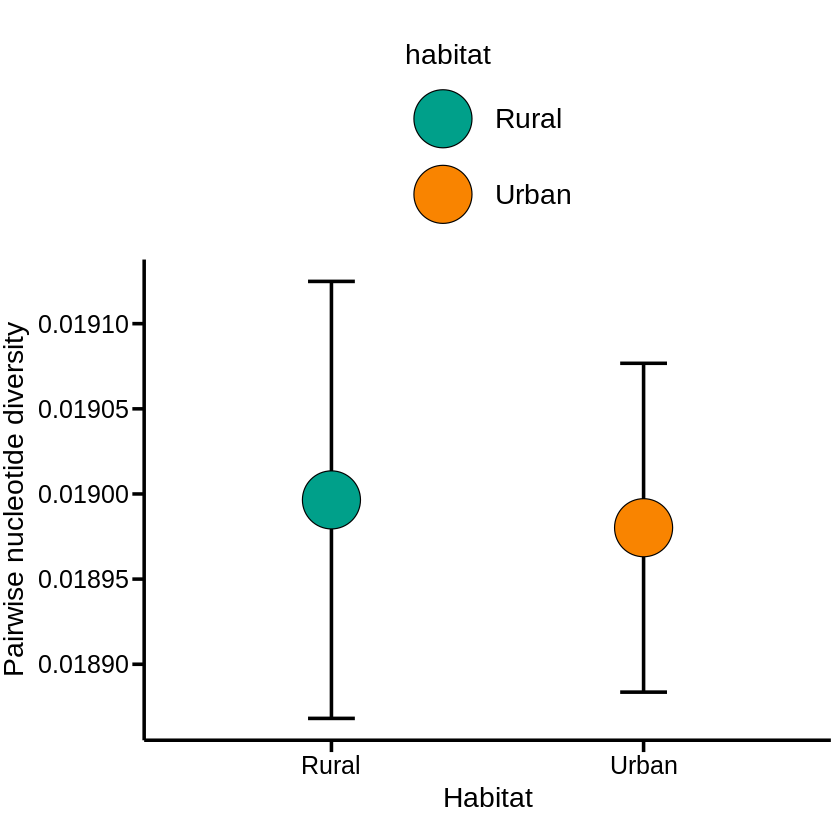

In [10]:
pi_by_habitat <- obs_div_df %>% 
    group_by(habitat) %>% 
    summarise(mean = mean(tp_scaled),
              sd = sd(tp_scaled),
              se = sd / sqrt(n())) %>% 
    mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
    ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
        geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.15, size = 1) +
        geom_point(size = 16, shape = 21) +
        scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
        ylab('Pairwise nucleotide diversity') + xlab('Habitat') +
    ng1
pi_by_habitat

In [11]:
outpath <- '../analyses/figures/main_text/figure3A_observed_pi_byHabitat.pdf'
ggsave(filename = outpath, plot = pi_by_habitat, device = 'pdf', width = 9, height = 8, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [12]:
# Model testing for difference in pi between urban and rural habitats
pi_mod <- aov(tp_scaled ~ city + habitat, data = obs_div_df)
summary(pi_mod)

            Df    Sum Sq   Mean Sq F value   Pr(>F)    
city        25 1.368e-05 5.473e-07   4.447 0.000198 ***
habitat      1 3.000e-09 3.500e-09   0.028 0.868052    
Residuals   25 3.077e-06 1.231e-07                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [13]:
# Least squared means of pi in each habitat
emmeans(pi_mod, specs = 'habitat')

 habitat emmean       SE df lower.CL upper.CL
 r        0.019 6.88e-05 25   0.0189   0.0191
 u        0.019 6.88e-05 25   0.0188   0.0191

Results are averaged over the levels of: city 
Confidence level used: 0.95 

#### Figure 3B

- Slope of HCN cline vs. difference in pi

In [14]:
pal <- c("#909090", "#FF0000", "#046C9A")

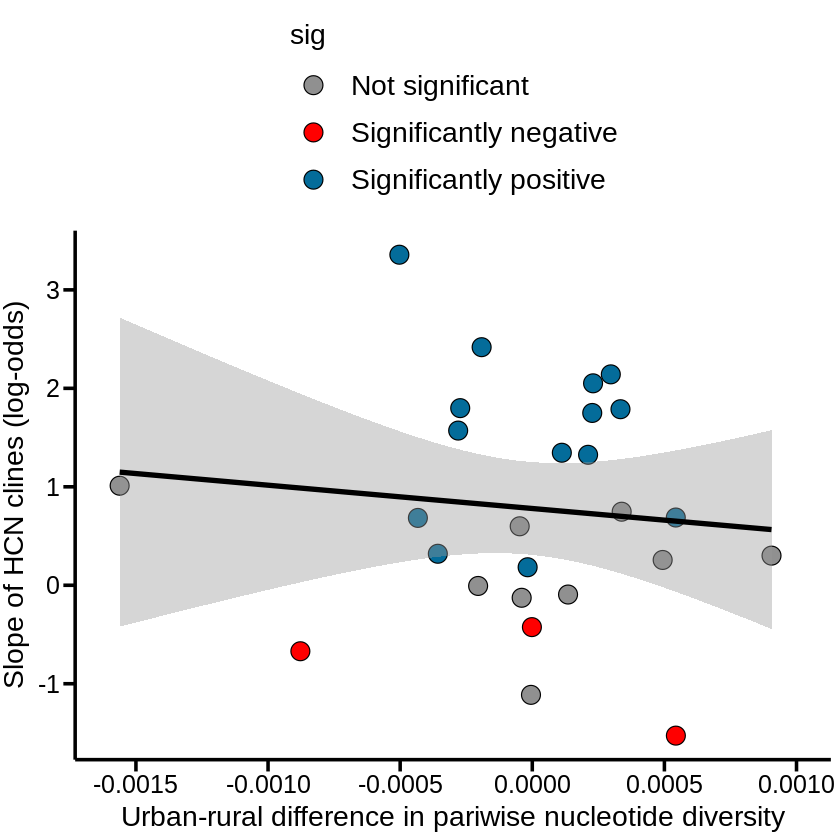

In [15]:
slope_by_PIdiff <- ggplot(obs_div_df_wide, aes(x = tp_diff, y = betaLog_fromGlobalModel)) +
    geom_point(size = 5, aes(fill = sig), shape = 21) +
    geom_smooth(method = 'lm', color = 'black', size = 1.5, formula = y ~ x) +
    scale_fill_manual(values = pal) +
    coord_cartesian(xlim = c(-0.0016, 0.001)) +
    scale_x_continuous(breaks = seq(from = -0.0015, to = 0.001, by = 0.0005)) +
    ylab('Slope of HCN clines (log-odds)') + xlab('Urban-rural difference in pariwise nucleotide diversity') +
    ng1
slope_by_PIdiff

In [16]:
outpath <- '../analyses/figures/main_text/figure3B_betaLog_vs_piDiff.pdf'
ggsave(filename = outpath, plot = slope_by_PIdiff, device = 'pdf', width = 9, height = 8, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [17]:
# Model testing relationship between the slope of clines and the urban-rural difference in pi
div_mod <- aov(betaLog_fromGlobalModel ~ tp_diff, data = obs_div_df_wide)
summary(div_mod)

            Df Sum Sq Mean Sq F value Pr(>F)
tp_diff      1   0.34  0.3443   0.254  0.619
Residuals   24  32.53  1.3554               

In [18]:
# Model testing whether the urban-rural difference in pi varies by whether there is a cline or not
tpDiff_by_sig_mod <- aov(tp_diff ~ sigLog, data = obs_div_df_wide)
summary(tpDiff_by_sig_mod)

            Df   Sum Sq   Mean Sq F value Pr(>F)
sigLog       1 4.00e-09 4.350e-09   0.017  0.897
Residuals   24 6.15e-06 2.562e-07               

In [19]:
emmeans(tpDiff_by_sig_mod, specs = 'sigLog')

 sigLog    emmean       SE df  lower.CL upper.CL
 No      1.45e-06 0.000169 24 -0.000347 0.000350
 Yes    -2.57e-05 0.000123 24 -0.000279 0.000228

Confidence level used: 0.95 

#### Figure S4A

- Permuted distribution of difference in pi by city with observed values overlaid

In [20]:
perm_div_df_wide <- perm_div_df %>% 
    # Calculate urban-rural difference in theta
    pivot_wider(names_from = habitat, values_from = c(tp_scaled, tw_scaled, nSites)) %>% 
    mutate(tp_diff = tp_scaled_u - tp_scaled_r) %>% 
    left_join(., betaLog_df, by = 'city')  %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant')) %>% 
    dplyr::select(city, seed, tp_scaled_r, tp_scaled_r, nSites_r, nSites_u, tp_diff, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig)
head(perm_div_df_wide)

,city,seed,tp_scaled_r,nSites_r,nSites_u,tp_diff,betaLog_Dist,pvalLog_Dist,betaLog_fromGlobalModel,sig
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Albuquerque,1,0.01907590,232390,232201,1.799579e-04,-0.839,0.004,-0.425,Significantly negative
2,Albuquerque,10,0.01910077,232303,232309,1.153783e-04,-0.839,0.004,-0.425,Significantly negative
3,Albuquerque,100,0.01907202,231769,232748,1.471660e-04,-0.839,0.004,-0.425,Significantly negative
4,Albuquerque,11,0.01921308,232674,231791,-9.423569e-05,-0.839,0.004,-0.425,Significantly negative
5,Albuquerque,12,0.01918768,231491,232925,-6.062250e-05,-0.839,0.004,-0.425,Significantly negative
6,Albuquerque,13,0.01919267,232903,231480,-1.071175e-04,-0.839,0.004,-0.425,Significantly negative


Picking joint bandwidth of 8.13e-05


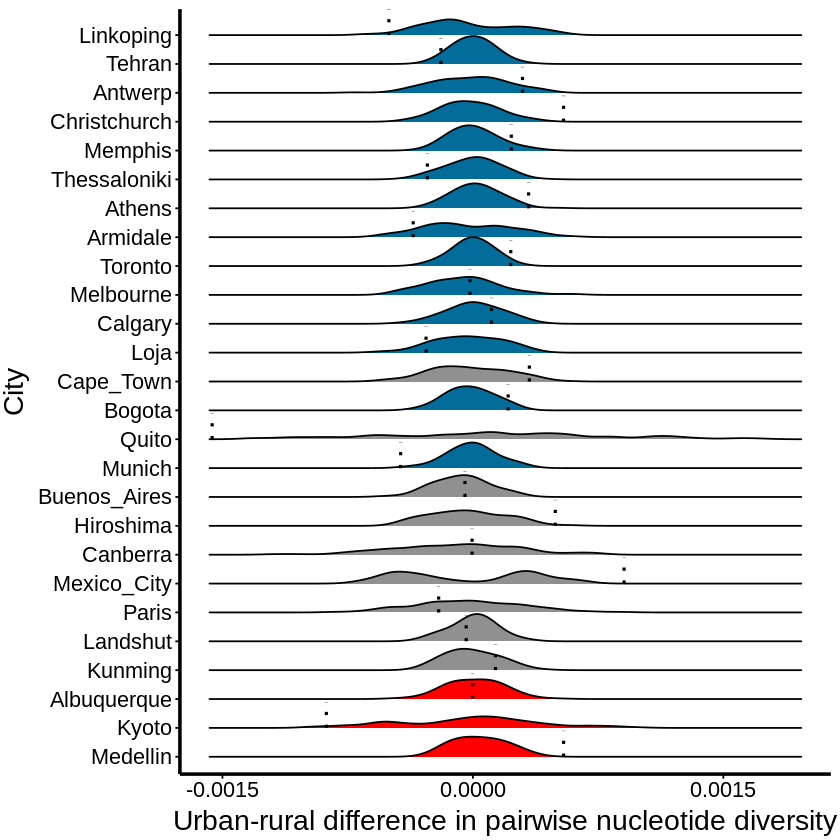

In [21]:
pal <- c("#909090", "#FF0000", "#046C9A")
piDiff_perm_byCity <- perm_div_df_wide %>% 
    ggplot(., aes(x = tp_diff, y = city, fill = sig)) +
    geom_density_ridges(scale = 1, show.legend = FALSE) +
    geom_segment(data = obs_div_df_wide, aes(x = tp_diff, xend = tp_diff, y = as.numeric(as.factor(city)), 
                                             yend = as.numeric(as.factor(city)) + 0.9),
                color = 'black', size = 0.9, linetype = 'dotted') +
    ylab('City') + xlab('Urban-rural difference in pairwise nucleotide diversity') +
    scale_fill_manual(values = pal) +
    scale_x_continuous(breaks = seq(from = -0.015, to = 0.015, by = 0.0015)) +
    theme_classic() + theme(axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"))
piDiff_perm_byCity

In [22]:
outpath <- '../analyses/figures/supplemental/figureS4A_piDiff_permutation_byCity.pdf'
ggsave(filename = outpath, plot = piDiff_perm_byCity, device = 'pdf', 
       width = 12, height = 12, units = 'in', dpi = 600, useDingbats = FALSE)

Picking joint bandwidth of 8.13e-05


In [23]:
div_df <- bind_rows(obs_div_df_wide, perm_div_df_wide)
div_pval_df <- div_df %>% 
    group_split(city) %>% 
    purrr::map_dfr(., var = 'tp_diff', permutation_pval) %>% 
    rename('pval_perm' = 'pval')

In [24]:
# Write diversity permutation pvals to disc
write_csv(div_pval_df, '../analyses/tables/pi_permutation_pvals.csv')

In [25]:
chsq_pi_df <- obs_div_df_wide %>% 
    left_join(div_pval_df, by = 'city') %>% 
    mutate(sig_perm = ifelse(pval_perm < 0.05, 'Yes', 'No')) %>% 
    dplyr::select(city, sigLog, sig_perm)

In [26]:
chisq_pi_table <- table(chsq_pi_df$sigLog, chsq_pi_df$sig_perm)
chisq_pi_table

     
      No Yes
  No   6   3
  Yes 12   5

In [27]:
chisq.test(chisq_pi_table, correct = FALSE)

Warning message in chisq.test(chisq_pi_table, correct = FALSE):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  chisq_pi_table
X-squared = 0.042484, df = 1, p-value = 0.8367


## Urban-rural differentiation

1. Look at urban-rural $F_{ST}$ across cities
2. See if variation in $F_{ST}$ predicts variation in the strength of clines

### Observed

In [28]:
# Mean Fst
obs_fst_df %>% 
    summarise(mean = mean(fst),
              sd = sd(fst),
              se = sd / sqrt(n()))

mean,sd,se
<dbl>,<dbl>,<dbl>
0.01193026,0.008459393,0.001659023


In [29]:
# Mean, min, and max number of sites
print(mean(obs_fst_df$nSites))
print(range(obs_fst_df$nSites))

[1] 225785.3
[1] 186401 235166


In [30]:
# Which cities have min and max number of sites
obs_fst_df %>% filter(nSites == min(nSites) | nSites == max(nSites))

city,fst,num_sum,denom_sum,nSites,betaLog_Dist,pvalLog_Dist,betaLog_fromGlobalModel,sig,sigLog
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Hiroshima,0.044057875,147.96018,3358.314,186401,-0.043,0.842,0.257,Not significant,No
Toronto,0.005500285,24.35982,4428.828,235166,1.463,0.000,1.750,Significantly positive,Yes


#### Figure 3C

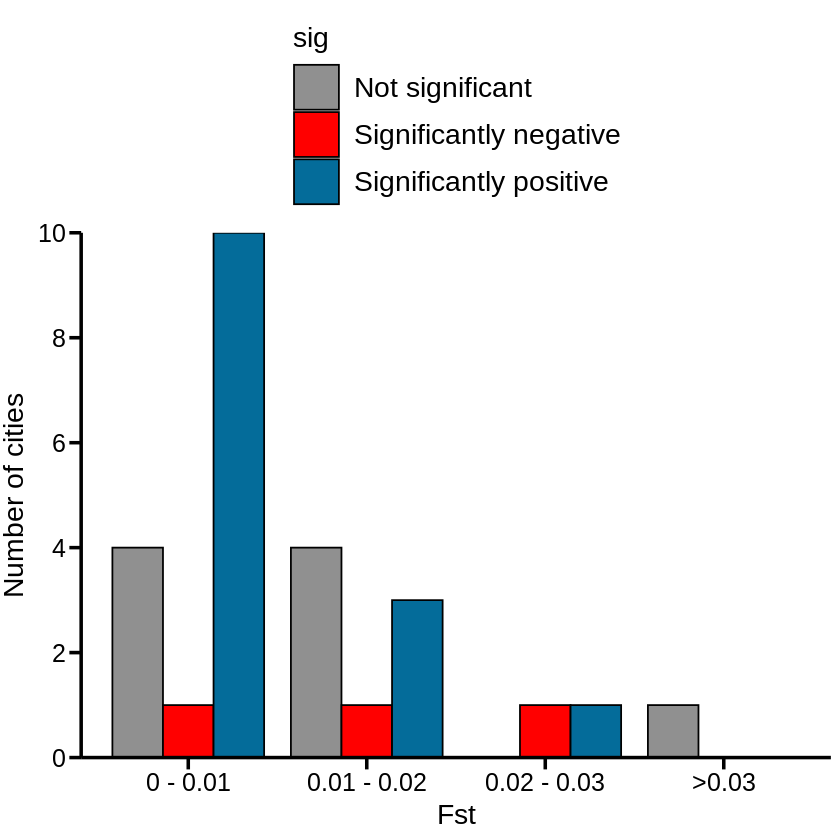

In [31]:
fst_by_cline <- obs_fst_df %>% 
    mutate(bin = case_when(fst > 0 & fst < 0.01 ~ '0 - 0.01',
                           fst > 0.01 & fst < 0.02 ~ '0.01 - 0.02',
                           fst > 0.02 & fst < 0.03 ~ '0.02 - 0.03',
                           fst > 0.03 ~ '>0.03')) %>% 
    mutate(bin = fct_relevel(bin, "0 - 0.01", "0.01 - 0.02", "0.02 - 0.03", ">0.03")) %>% 
#     mutate(sig = fct_relevel(sig, "Significantly negative", "Not significant", "Significantly positive")) %>% 
    group_by(sig, bin) %>% 
    summarise(n = n(), .groups = 'drop') %>% 
    complete(bin, sig, fill = list(n = 0)) %>% 
    ggplot(., aes(x = bin, y = n, fill = sig)) +
    geom_bar(stat = 'identity', color = 'black', width = 0.85, position = 'dodge') +
    scale_fill_manual(values = pal) +
    xlab('Fst') + ylab('Number of cities') +
    scale_y_continuous(breaks = seq(from = 0, to = 10, by = 2), expand = c(0,0)) +
    ng1
fst_by_cline

In [32]:
outpath <- '../analyses/figures/main_text/figure3C_fstCounts_byClineSignificance.pdf'
ggsave(filename = outpath, plot = fst_by_cline, device = 'pdf', width = 9, height = 8, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [33]:
# Model testing whether Fst differs between cities with and without clines
fst_mod <- aov(fst ~ sigLog, data = obs_fst_df)
summary(fst_mod)

            Df    Sum Sq   Mean Sq F value Pr(>F)
sigLog       1 0.0001035 1.035e-04   1.474  0.237
Residuals   24 0.0016855 7.023e-05               

In [34]:
emmeans(fst_mod, specs = 'sigLog')

 sigLog emmean      SE df lower.CL upper.CL
 No     0.0147 0.00279 24  0.00891   0.0204
 Yes    0.0105 0.00203 24  0.00628   0.0147

Confidence level used: 0.95 

#### Figure 3D

- Slope of clines vs. Fst

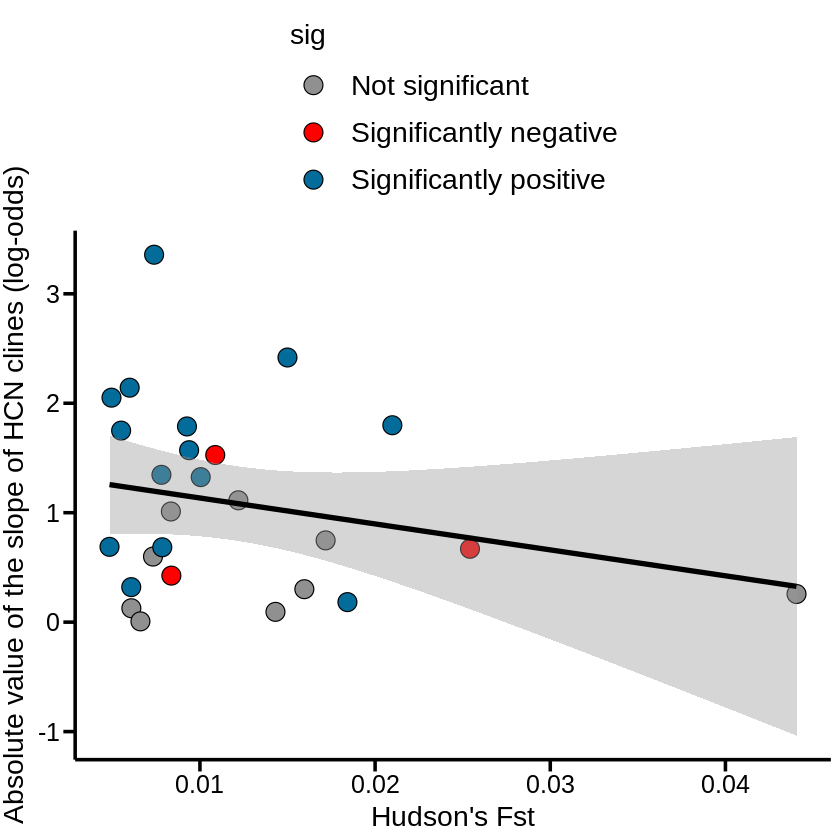

In [68]:
slope_by_fst <- ggplot(obs_fst_df, aes(x = fst, y = abs(betaLog_fromGlobalModel))) +
    geom_point(size = 5, aes(fill = sig), shape = 21) +
    geom_smooth(method = 'lm', color = 'black', size = 1.5, formula = y ~ x) +
    scale_fill_manual(values = pal) +
    scale_y_continuous(breaks = seq(from = -4, to = 4, by = 1)) +
    ylab('Absolute value of the slope of HCN clines (log-odds)') + xlab("Hudson's Fst") +
    ng1
slope_by_fst

In [69]:
outpath <- '../analyses/figures/main_text/figure3D_betaLog_by_fst.pdf'
ggsave(filename = outpath, plot = slope_by_fst, device = 'pdf', width = 9, height = 8, units = 'in',
      useDingbats = FALSE, dpi = 600)

In [50]:
# Model testing whether Fst predicts the strength of clines
fst_mod <- aov(abs(betaLog_fromGlobalModel) ~ fst, data = obs_fst_df)
summary(fst_mod)

            Df Sum Sq Mean Sq F value Pr(>F)
fst          1  1.005  1.0048   1.416  0.246
Residuals   24 17.032  0.7097               

### Permuted

#### Figure S4B

Picking joint bandwidth of 0.000423


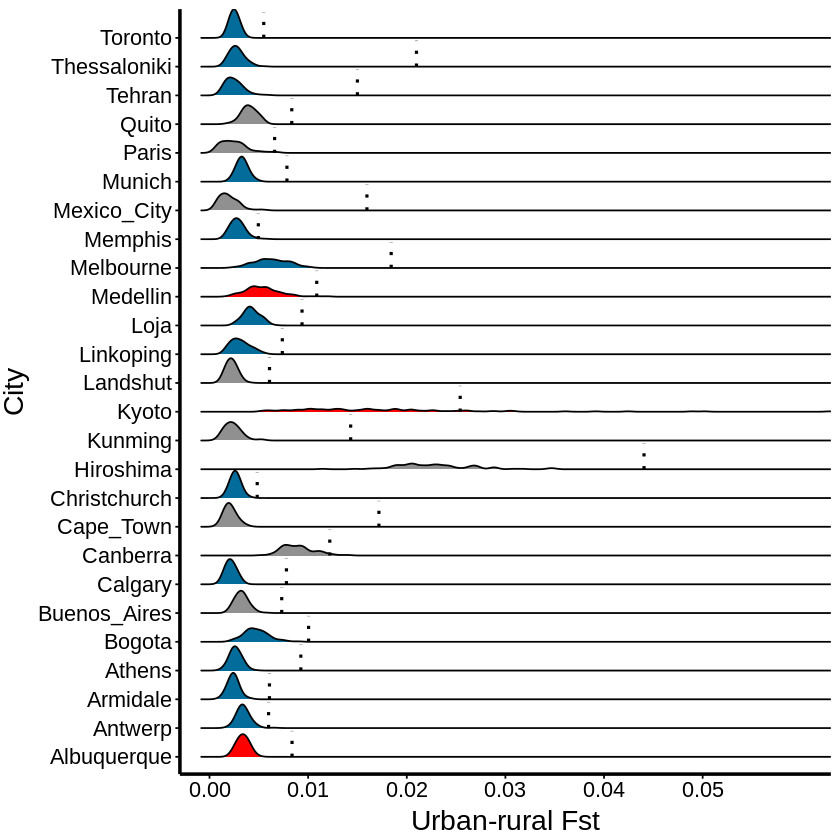

In [51]:
fst_perm_byCity <- perm_fst_df %>% 
    ggplot(., aes(x = fst, y = city, fill = sig)) +
    geom_density_ridges(scale = 1, show.legend = FALSE) +
    geom_segment(data = obs_fst_df, aes(x = fst, xend = fst, y = as.numeric(as.factor(city)), 
                                             yend = as.numeric(as.factor(city)) + 0.9),
                color = 'black', size = 0.9, linetype = 'dotted') +
    ylab('City') + xlab('Urban-rural Fst') +
    scale_fill_manual(values = pal) +
    coord_cartesian(xlim = c(0, 0.06)) +
    scale_x_continuous(breaks = seq(from = 0, to = 0.05, by = 0.01)) +
    theme_classic() + theme(axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"))
fst_perm_byCity

In [52]:
outpath <- '../analyses/figures/supplemental/figureS4B_fst_permutation_byCity.pdf'
ggsave(filename = outpath, plot = fst_perm_byCity, device = 'pdf', 
       width = 12, height = 12, units = 'in', dpi = 600, useDingbats = FALSE)

Picking joint bandwidth of 0.000423


In [53]:
fst_df <- bind_rows(obs_fst_df, perm_fst_df)
fst_pval_df <- fst_df %>% 
    group_split(city) %>% 
    purrr::map_dfr(., var = 'fst', permutation_pval) %>% 
    rename('pval_perm' = 'pval')

In [54]:
# Write diversity permutation pvals to disc
write_csv(fst_pval_df, '../analyses/tables/fst_permutation_pvals.csv')

In [55]:
chsq_fst_df <- obs_fst_df %>% 
    left_join(fst_pval_df, by = 'city') %>% 
    mutate(sig_perm = ifelse(pval_perm < 0.05, 'Yes', 'No')) %>% 
    dplyr::select(city, sigLog, sig_perm)

In [56]:
chisq_fst_table <- table(chsq_fst_df$sigLog, chsq_fst_df$sig_perm)
chisq_fst_table

     
      No Yes
  No   1   8
  Yes  1  16

In [57]:
chisq.test(chisq_fst_table, correct = FALSE)

Warning message in chisq.test(chisq_fst_table, correct = FALSE):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  chisq_fst_table
X-squared = 0.22658, df = 1, p-value = 0.6341


### Euclidean distance from PCA

- Estimate Euclidean distance between urban and rural centroids by city

In [58]:
pca_importance(summary(princomp(cov_mat))) %>% 
    as.data.frame() %>% 
    rownames_to_column('var') %>% 
    dplyr::select(var, Comp.1:Comp.4)

var,Comp.1,Comp.2,Comp.3,Comp.4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,0.7188854,0.47964450,0.37329217,0.35081533
Proportion of Variance,0.1686285,0.07506725,0.04546837,0.04015769
Cumulative Proportion,0.1686285,0.24369575,0.28916411,0.32932180


In [59]:
# Dataframe with eigenvectors
eigenvectors <- eigen(cov_mat)
eigen_df <- eigenvectors$vectors %>% 
    as.data.frame() %>% 
    dplyr::select(V1, V2) %>% 
    rename('PC1' = 'V1',
           'PC2' = 'V2') %>% 
    bind_cols(., samples)

In [60]:
euc_dist_df <- eigen_df %>% 
    group_by(city, site) %>% 
    summarise(x = mean(PC1),
              y = mean(PC2),
             .groups = 'drop') %>% 
    pivot_wider(names_from = site, values_from = c(x, y)) %>% 
    mutate(pca_distance = euclidean(x_u, y_u, x_r, y_r)) %>% 
    dplyr::select(city, pca_distance) %>% 
    left_join(., betaLog_df, by = 'city')

In [61]:
head(euc_dist_df)

city,pca_distance,yint_Dist,betaLog_Dist,pvalLog_Dist,yint_GMIS,betaLog_GMIS,pvalLog_GMIS,yint_hii,betaLog_hii,pvalLog_hii,continent,betaLog_fromGlobalModel
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Albuquerque,0.006470112,-0.825,-0.839,0.004,-1.236,0.021,0.955,-1.604,0.781,0.000,North America,-0.425
Antwerp,0.005173246,-2.234,2.150,0.000,-0.613,-2.196,0.000,-0.308,-1.674,0.000,Europe,2.142
Armidale,0.003307576,0.215,1.487,0.000,1.216,-2.224,0.000,0.892,-0.162,0.425,Oceania,0.320
Athens,0.017485789,-0.586,1.565,0.000,0.295,-1.142,0.000,0.489,-0.858,0.000,North America,1.788
Bogota,0.007531273,-0.865,0.839,0.014,-0.064,-1.087,0.000,-0.296,-0.152,0.598,South America,1.325
Buenos_Aires,0.004265745,1.129,0.015,0.950,1.052,0.220,0.461,1.024,0.271,0.400,South America,0.599


In [62]:
# Does euclidean distance predict HCN?
dist_mod <- aov(betaLog_fromGlobalModel ~ pca_distance, data = euc_dist_df)
summary(dist_mod)

             Df Sum Sq Mean Sq F value Pr(>F)
pca_distance  1   1.15   1.151   0.871   0.36
Residuals    24  31.72   1.322               

#### Figure S5 

- PCA figure with urban/rural centroids

In [63]:
euc_dist_df_forPlot <- eigen_df %>% 
    group_by(city, site) %>% 
    summarise(x = mean(PC1),
              y = mean(PC2),
             .groups = 'drop')
head(euc_dist_df_forPlot)

city,site,x,y
<chr>,<chr>,<dbl>,<dbl>
Albuquerque,r,0.001076591,0.016321967
Albuquerque,u,0.005727100,0.011823622
Antwerp,r,-0.005840701,0.010520384
Antwerp,u,-0.010582627,0.012588381
Armidale,r,0.013326773,-0.006951741
Armidale,u,0.014177276,-0.010148098


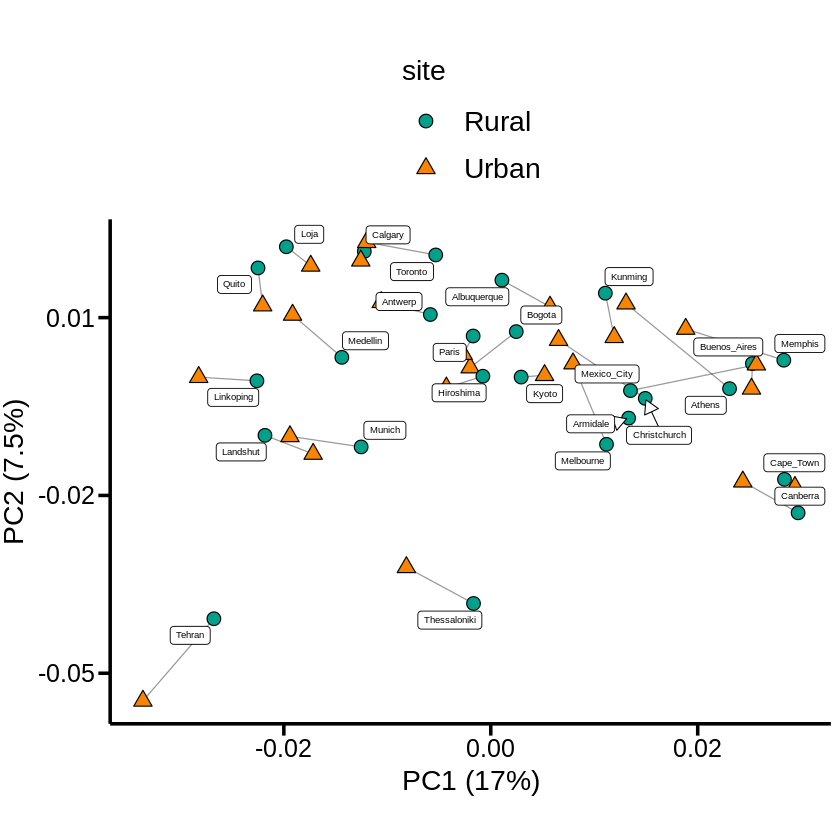

In [64]:
pca_centroids <- ggplot(euc_dist_df_forPlot, aes(x = x, y = y, fill = site, shape = site)) +
    geom_line(size = 0.35, alpha = 0.4, aes(group = city)) +
    geom_point(size = 3.5) +
    scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
    scale_shape_manual(values = c(21, 24), labels = c('Rural', 'Urban')) +
    scale_x_continuous(breaks = seq(from = -0.08, to = 0.06, by = 0.02)) +
    scale_y_continuous(breaks = seq(from = -0.05, to = 0.15, by = 0.03)) +
    ylab('PC2 (7.5%)') + xlab("PC1 (17%)") + 
    geom_label_repel(data = euc_dist_df_forPlot %>% filter(site == 'r'),
                     aes(label = city),
                        color = 'black',
                        fill = 'white', 
                        size = 2,
                        arrow = arrow(length = unit(0.03, "npc"), 
                        type = "closed", ends = "last"),
#                         nudge_y = 0.1,
                        segment.size  = 0.3) +
    ng1
pca_centroids

In [65]:
outpath <- '../analyses/figures/supplemental/figureS5_pca_centroids.pdf'
ggsave(filename = outpath, plot = pca_centroids, device = 'pdf', 
       width = 9, height = 8, units = 'in', dpi = 600, useDingbats = FALSE)

## Urban-rural admixture

In [66]:
admixture_plot <- function(df){
    
    city <- df %>% pull(city) %>% unique()
    cols <- c('#D69D13', '#BB2F10')
    plot <- df %>% 
        mutate(site = ifelse(site == 'r', 'Rural', 'Urban')) %>% 
        ggplot(., aes(factor(sample), Probs, fill = factor(name), color = factor(name))) +
            geom_col(size = 0.1) +
            facet_grid(~fct_inorder(site), switch = "x", scales = "free", space = "free") +
            theme_minimal() + labs(x = "Individuals", title = sprintf("%s (K=2)", city), y = "Ancestry") +
            scale_y_continuous(expand = c(0, 0)) +
            scale_x_discrete(expand = expansion(add = 1)) +
            scale_fill_manual(values = cols) + 
            scale_color_manual(values = cols) +
            theme(
                legend.position = 'none',
                panel.spacing.x = unit(0.1, "lines"),
                axis.text.x = element_blank(),
                panel.grid = element_blank(),
                axis.text.y = element_blank(),
                axis.title.y = element_blank(),
                axis.title.x = element_blank(),
                plot.title = element_text(size = 16),
                strip.text.x = element_text(size = 13)
            ) 
}

admix_plots <- admix_df %>% 
    group_split(city) %>% 
    map(., admixture_plot)

In [67]:
admix_plot_out <- patchwork::wrap_plots(admix_plots, ncol = 3, nrow = 9)
outpath <- '../analyses/figures/supplemental/figureS6_admixture.pdf'
ggsave(filename = outpath, plot = admix_plot_out, device = 'pdf', 
       width = 14, height = 14, units = 'in', dpi = 600, useDingbats = FALSE)

# Generate summary datasets

**Note: This section only needs to be run to generate the summary datasets from the raw data output by the Snakemake pipeline. If the Snakemake pipeline hasn't been run, then the manuscript's results can be reproduced by running the analyses above using the summary datasets, which are available on [GitHub](../analyses/tables) and archived on Zenodo**

## Functions used to generate summary datasets

In [79]:
# Function to load observed diversity estimates by city and habitat
load_obs_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(path)
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    
    full_path <- paste0(inpath, path)
    
    # Load dataframe
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site) %>% 
    
    # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat) %>% 
        summarise(tp_scaled = mean(tp_scaled),
                  tw_scaled = mean(tw_scaled),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, habitat, tp_scaled, tw_scaled, nSites)

    return(df)
    
}

# Function to load permuted diversity estimates by city and habitat
load_permuted_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(dirname(path))
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')

    
    full_path <- paste0(inpath, path)
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site,
               seed = seed) %>% 
        # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat, seed) %>% 
        summarise(tp_scaled = mean(tp_scaled),
                  tw_scaled = mean(tw_scaled),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, habitat, seed, tp_scaled, tw_scaled, nSites)

    return(df)
    
}

# Function to load observed Fst df by city/habitat
load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(path)
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city)
    
    return(df)
    
}

# Function to load permuted Fst df by city/habitat
load_perm_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(dirname(path))
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city,
               seed = seed)
    
    return(df)
    
}

# Function to load admixture results from PCAngsd
load_admixture <- function(path){
    
    city <- basename(dirname(path))
    bam_list_path <- '../../../results/program_resources/bam_lists/by_city/'
    samples <- suppressMessages(list.files(paste0(bam_list_path, city, '/'), 
                          pattern = '*lowCovRemoved*', 
                          full.names = TRUE) %>% 
        read_table(., col_names = FALSE)) %>% 
        mutate(sample = str_extract(X1, '(?<=\\/)\\w+_\\d+_\\d+(?=_4fold)')) %>% 
        pull(sample)
    
    df <- npyLoad(path) %>% 
        as_tibble() %>% 
        mutate(city = city,
               sample = samples)
    return(df)
}

## Write dataframes

### Urban-rural genetic diversity

In [72]:
# Concatenate urban and rural genetic diversity results (N = 2 habitats x 26 citis = 52) into single dataframe
inpath <- '../../../results/angsd/summary_stats/thetas/by_city/'
obs_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_obs_pairwise_diversity)

# Write observed data to disc
write_delim(obs_div_df, '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

In [74]:
# Permuted urban and rural pi
perm_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold_seed.*.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_permuted_pairwise_diversity) 

# Write permuted values to disc
write_delim(perm_div_df, '../analyses/tables/div_popStruct/permuted_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/permuted_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

### Urban-rural Fst

In [75]:
# Merge Fst dataframes. Using Hudson's Fst
inpath <- '../../../results/angsd/summary_stats/hudson_fst/'
obs_fst_df <- list.files(inpath, pattern = '.*_4fold_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_obs_fst) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant'),
          sigLog = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No'))  %>% 
    dplyr::select(city, fst, num_sum, denom_sum, nSites, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig, sigLog)

# Write observed Fst values to disc
write_delim(obs_fst_df, '../analyses/tables/div_popStruct/observed_fst.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_fst.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

In [76]:
# Merge Fst dataframes. Only using Hudson's Fst
inpath <- '../../../results/angsd/summary_stats/hudson_fst/'
perm_fst_df <- list.files(inpath, pattern = '.*seed\\d+_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_perm_fst) %>% 
    left_join(., betaLog_df, by = 'city') %>% 
    as.data.frame() %>% 
    mutate(city = fct_reorder(as.factor(city), betaLog_Dist),
           sig = case_when(betaLog_Dist > 0 & pvalLog_Dist < 0.05 ~ 'Significantly positive',
                           betaLog_Dist < 0 & pvalLog_Dist < 0.05 ~ 'Significantly negative',
                           TRUE ~ 'Not significant')) %>% 
    dplyr::select(city, seed, fst, num_sum, denom_sum, nSites, betaLog_Dist, pvalLog_Dist, betaLog_fromGlobalModel, sig)

# Write permuted Fst values to disc
write_delim(perm_fst_df, '../analyses/tables/div_popStruct/permuted_fst.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/permuted_fst.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

### PCA

**Note: I manually copied the output of `PCAngsd` into the [tables](../analyses/table/div_popStruct/) directory and bgzipped it. This way full PCA is easier to reproduce (e.g., estimating % var explained by each PC)**

### Admixture

In [81]:
inpath <- '../../../results/population_structure/pcangsd/by_city/'
ss <- suppressMessages(
    read_delim(
        '../resources/glue_pc_sampleSheet.txt', 
                           delim = '\t')) %>% 
    dplyr::select(site, sample)
admix_df <- list.files(inpath, pattern = '*.Q.npy', recursive = TRUE, full.names = TRUE) %>% 
    map_dfr(., load_admixture) %>% 
    left_join(., ss, by = 'sample') %>% 
    pivot_longer(V1:V2, values_to = 'Probs')

# Write admixture dataframe to disc
write_delim(admix_df, '../analyses/tables/div_popStruct/admixture.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/admixture.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

In [82]:
# Write summary datasets to disc so analyses can be reproduced without running the pipeline
# This only needs to be run once and datasets with be git controlled and placed in data repositories
write_csv(obs_div_df, '../analyses/tables/observed_urban-rural_pi.csv')
write_csv(perm_div_df, '../analyses/tables/permuted_urban-rural_pi.csv')
write_csv(obs_fst_df, '../analyses/tables/observed_fst.csv')
write_csv(perm_fst_df, '../analyses/tables/permuted_fst.csv')
write_csv(eigen_df, '../analyses/tables/pca_eigen.csv')